# 1. Business Problem

## 1.1 Introdução ao Problema

Você foi contratado(a) para fazer uma análise apurada do número de internações no
sistema de saúde brasileiro. Esta análise é de extrema importância para tomada de
decisões que deverão contribuir para melhorias no sistema e planejamento estratégico.

Para a análise foram fornecidos os dados referentes às internações que ocorreram no país durante o período de dez/17 a jul/19, separados por região e unidade de federação. 

Nosso objetivo é, através do dados, montar um planejamento estratégico para diminuir o número de internações em hospitais do SUS.

# 2. Data cleaning

## 2.1 Library imports and settings

In [1]:
# imports que suportam o notebook
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
from unidecode import unidecode
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.ar_model import AutoReg
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

/home/julia-penalva/.pyenv/versions/3.10.1/lib/python3.10/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


## 2.2 Data Import

In [2]:
# importando os dados do excel disponível
dfname=pd.ExcelFile('case_internacao_SUS.xls')
sheets = dfname.sheet_names

df=pd.DataFrame()

for sheet in sheets:
    xls = pd.ExcelFile('case_internacao_SUS.xls')
    data = pd.read_excel(xls, sheet)
    df = pd.concat([df, data], axis = 0)

df.reset_index(drop = True, inplace = True)

In [3]:
# olhando pela primeira vez nossos dados para entendermos o que faremos primeiro
df

,Região/Unidade da Federação,Internações,AIH_aprovadas,Valor_total,Valor_serviços_hospitalares,Val_serv_hosp_-_compl_federal,Val_serv_hosp_-_compl_gestor,Valor_serviços_profissionais,Val_serv_prof_-_compl_federal,Val_serv_prof_-_compl_gestor,Valor_médio_AIH,Valor_médio_intern,Dias_permanência,Média_permanência,Óbitos,Taxa_mortalidade
0,Região Norte,75363.000,75363.000,65821821.590,50592273.100,282125.280,-,14820122.530,-,-,873.400,873.400,358202.000,4.800,2149.000,2.850
1,.. Rondônia,9603.000,9603.000,9404751.410,7666945.900,-,-,1737805.510,-,-,979.360,979.360,53043.000,5.500,315.000,3.280
2,.. Amazonas,16248.000,16248.000,15624312.730,12166634.070,1221.310,-,3455637.920,-,-,961.610,961.610,85512.000,5.300,536.000,3.300
3,.. Roraima,4324.000,4324.000,3137537.400,2356231.680,-,-,781305.720,-,-,725.610,725.610,25560.000,5.900,171.000,3.950
4,.. Pará,34774.000,34774.000,28178633.440,21241354.070,248197.250,-,6581738.700,-,-,810.340,810.340,138135.000,4.000,832.000,2.390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,.. Mato Grosso,14710.000,14786.000,15262067.840,12257906.250,970.380,-,3002675.520,-,-,1032.200,1037.530,69397.000,4.700,617.000,4.190
476,.. Goiás,26070.000,26646.000,33599752.120,26623057.010,327025.060,220665.440,6267858.480,220665.440,7093.390,1260.970,1288.830,125461.000,4.800,920.000,3.530
477,.. Distrito Federal,18473.000,18502.000,18496333.160,14775080.570,-,-,3721252.590,-,-,999.690,1001.260,104719.000,5.700,499.000,2.700
478,Total,947202.000,961714.000,1226362165.530,977366196.170,3253568.730,350177.940,243394470.770,350177.940,244937.510,1275.180,1294.720,4968008.000,5.200,39496.000,4.170


A princípio, vemos dados faltantes e a coluna de Região/Unidade da Federação precisando de formatação. Vamos explorar também os tipos atriuídos às variáveis e analisar as outras colunas para identificarmos necessidade de tratamento de dados faltantes.

## 2.3 Data processing

Nessa etapa vamos fazer a limpeza e formatação dos dados.

**Nomes das colunas**

A primeira coisa que vamos fazer é trocar o nome das colunas para que seja mais fácil trabalhar com elas, para isso foram usadas siglas, explicadas abaixo: 
* AIH: Autorização de Internação Hospitalar
* VSH: Valor dos Serviços Hospitalares
* VSP: Valor dos Serviços Profissionais

In [4]:
df = df.rename(columns = {
                'Valor_serviços_hospitalares': 'vsh',
                'Val_serv_hosp_-_compl_federal': 'vsh_comp_fed',
                'Val_serv_hosp_-_compl_gestor': 'vsh_comp_gest',
                'Valor_serviços_profissionais': 'vsp',
                'Val_serv_prof_-_compl_federal': 'vsp_comp_fed',
                'Val_serv_prof_-_compl_gestor': 'vsp_comp_gest',
                'Região/Unidade da Federação': 'estado',
                'AIH_aprovadas': 'aih_aprvd',
                'Valor_total': 'valor_total',
                'Valor_médio_AIH': 'valor_medio_aih',
                'Valor_médio_intern': 'valor_medio_intern',
                'Dias_permanência': 'dias_permanencia',
                'Média_permanência': 'media_permanencia',
                'Óbitos': 'obitos',
                'Taxa_mortalidade': 'taxa_mortalidade',
                'Internações': 'internacoes'
        })

**Tipos das colunas**

In [5]:
df.dtypes

estado                 object
internacoes           float64
aih_aprvd             float64
valor_total           float64
vsh                   float64
vsh_comp_fed           object
vsh_comp_gest          object
vsp                   float64
vsp_comp_fed           object
vsp_comp_gest          object
valor_medio_aih       float64
valor_medio_intern    float64
dias_permanencia      float64
media_permanencia     float64
obitos                float64
taxa_mortalidade      float64
dtype: object

Aparentemente os tipos das variáveis Val_serv_hosp_-_compl_federal, Val_serv_hosp_-_compl_gestor, Val_serv_prof_-_compl_federal e Val_serv_prof_-_compl_gestor_ estão incorretos, dado que são valores numéricos. 

Para isso, vamos ter que substituir os valores de '-' por 0 e posteriormente transformar o tipo das colunas, como demonstrado abaixo:

In [6]:
# , Val_serv_hosp_-_compl_gestor, Val_serv_prof_-_compl_federal e Val_serv_prof_-_compl_gestor_
df['vsh_comp_fed'] = df['vsh_comp_fed'].apply(lambda x: str(x).replace('-', '0'))
df['vsh_comp_fed'] = df['vsh_comp_fed'].astype('float')

df['vsh_comp_gest'] = df['vsh_comp_gest'].apply(lambda x: str(x).replace('-', '0'))
df['vsh_comp_gest'] = df['vsh_comp_gest'].astype('float')

df['vsp_comp_fed'] = df['vsp_comp_fed'].apply(lambda x: str(x).replace('-', '0'))
df['vsp_comp_fed'] = df['vsp_comp_fed'].astype('float')

df['vsp_comp_gest'] = df['vsp_comp_gest'].apply(lambda x: str(x).replace('-', '0'))
df['vsp_comp_gest'] = df['vsp_comp_gest'].astype('float')

**Coluna 'estado' - primeira limpeza**

Vamos fazer duas etapas de limpeza na coluna 'estado': 

    1- Primeiramente vamos retirar quaisquer valores nulos e as sujeiras nos nomes dos estados;
    2- Depois vamos deixar a coluna somente com os nomes dos estados, retirando "Totais" e as regiões;

Essa segragação foi feita pois vamos usar a coluna de "Totais" como referência para acrescentarmos a coluna de as datas das observações e, posteriormente, criar uma coluna com as regiões.

In [7]:
# vendo os valores únicos na coluna de estado
df['estado'].unique()
# além dos estados que queremos manter, temos sujeiras como "Total", valores nulos e " " 

array(['Região Norte', '.. Rondônia', '.. Amazonas', '.. Roraima',
       '.. Pará', '.. Amapá', '.. Tocantins', 'Região Nordeste',
       '.. Maranhão', '.. Piauí', '.. Ceará', '.. Rio Grande do Norte',
       '.. Paraíba', '.. Pernambuco', '.. Alagoas', '.. Sergipe',
       '.. Bahia', 'Região Sudeste', '.. Minas Gerais',
       '.. Espírito Santo', '.. Rio de Janeiro', '.. São Paulo',
       'Região Sul', '.. Paraná', '.. Santa Catarina',
       '.. Rio Grande do Sul', 'Região Centro-Oeste',
       '.. Mato Grosso do Sul', '.. Mato Grosso', '.. Goiás',
       '.. Distrito Federal', 'Total', nan, ' ', '.. Acre'], dtype=object)

In [8]:
# observamos que as linhas cujo valor do estado era nulo ou vazio estavam completamente vazias, portanto serão deletadas
vazio = df[(df['estado'] == 'nan') | (df['estado'] == ' ')].index.to_list()
df.drop(labels = vazio, axis = 0, inplace = True)
df.reset_index(drop = True, inplace = True)
# como já fo comentado, vamos manter o "Total" para utilizarmos depois 

# deletando os .. no nome dos estados
df['estado'] = df['estado'].apply(lambda x: str(x).replace('.. ', ''))

**Acrescentar e tratar coluna de datas**

Do arquivo em excel que importamos os dados, cada aba representada um mês de observação. Para acrescentarmos essa dimensão aos nossos dados vamos utilizar a linha de 'Total', que representa o fim dos dados de cada uma das abas.

In [9]:
# primeiro criamos um dataframe só com as linhas de "Total" e seus índices
totais = df[df['estado'] == 'Total']
totais['month_year'] = sheets
totais = totais.reset_index()

# traduzindo os meses para inglês
totais['month_year'] = totais['month_year'].apply(lambda x: x.replace('fev','feb'))
totais['month_year'] = totais['month_year'].apply(lambda x: x.replace('abr','apr'))
totais['month_year'] = totais['month_year'].apply(lambda x: x.replace('mai','may'))
totais['month_year'] = totais['month_year'].apply(lambda x: x.replace('ago','aug'))
totais['month_year'] = totais['month_year'].apply(lambda x: x.replace('set','sep'))
totais['month_year'] = totais['month_year'].apply(lambda x: x.replace('out','oct'))
totais['month_year'] = totais['month_year'].apply(lambda x: x.replace('dez','dec'))

# mudando o tipo de data
totais['month_year'] = totais['month_year'].apply(lambda x: datetime.strptime(x,'%b%y')) 
totais.rename(columns={'month_year': 'date'}, inplace = True)

/tmp/ipykernel_14537/2776702178.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  totais['month_year'] = sheets


In [10]:
# vamos criar um novo dataframe, baseado no primeiro, mas com o index como coluna para unirmos ao total
df2 = df.reset_index()
df2 = pd.merge(df2, totais, how = 'left', on='index')

In [11]:
# agora vamos ajustar o df2
# dropamos colunas repetidas
dropped = ['estado_y', 'internacoes_y', 'aih_aprvd_y',
       'valor_total_y', 'vsh_y', 'vsh_comp_fed_y', 'vsh_comp_gest_y', 'vsp_y',
       'vsp_comp_fed_y', 'vsp_comp_gest_y', 'valor_medio_aih_y',
       'valor_medio_intern_y', 'dias_permanencia_y', 'media_permanencia_y',
       'obitos_y', 'taxa_mortalidade_y','index']
df2.drop(dropped, axis = 1, inplace = True)

## renomeando colunas
colunas = df.columns.to_list()
colunas.append('month_year')

df2.set_axis(colunas, axis = 1, inplace = True)

In [12]:
# preenchendo mês e ano para todas as ocorrências
df2['month_year'].bfill(inplace=True)

**Coluna 'estado' - segunda limpeza****

Agora que temos nossa coluna de datas preenchida no formato correto, podemos nos livrar das linhas de 'Totais' e segregar as regiões em uma nova coluna.

In [13]:
# dropando linhas de totais
list1 = df2[df2['estado'] == 'Total'].index
df2.drop(list1, axis = 0, inplace=True)

# criando a nova coluna de região e preenchendo ela
df2['regiao'] = df2['estado'].apply(lambda x: re.search('Região.+', x))
df2['regiao'] = df2['regiao'].apply(lambda x: x.group(0) if pd.notnull(x) else x)

df2['regiao'] = df2['regiao'].apply(lambda x: x.replace('Região Norte', 'norte') if pd.notnull(x) else x)
df2['regiao'] = df2['regiao'].apply(lambda x: x.replace('Região Nordeste', 'nordeste') if pd.notnull(x) else x)
df2['regiao'] = df2['regiao'].apply(lambda x: x.replace('Região Sudeste', 'sudeste') if pd.notnull(x) else x)
df2['regiao'] = df2['regiao'].apply(lambda x: x.replace('Região Sul', 'sul') if pd.notnull(x) else x)
df2['regiao'] = df2['regiao'].apply(lambda x: x.replace('Região Centro-Oeste', 'centro_oeste') if pd.notnull(x) else x)

df2['regiao'].ffill(inplace=True)

In [14]:
# dropando as linhas de região dentro da coluna de estado
list1 = df2[(df2['estado'] == 'Região Norte') | (df2['estado'] == 'Região Nordeste') | (df2['estado'] == 'Região Sudeste') | (df2['estado'] == 'Região Sul') | (df2['estado'] == 'Região Centro-Oeste')].index.to_list()

df2.drop(list1, axis = 0, inplace = True)

In [15]:
# ajustando o nome dos estados como snake_case
df2['estado'] = df2['estado'].apply(lambda x: x.lower())
df2['estado'] = df2['estado'].apply(lambda x: x.replace(' ', '_'))
df2['estado'] = df2['estado'].apply(lambda x: unidecode(x))

In [16]:
# rearrumando a ordem das colunas
df2 = df2[
['regiao',
 'estado',
 'internacoes',
 'aih_aprvd',
 'valor_total',
 'vsh',
 'vsh_comp_fed',
 'vsh_comp_gest',
 'vsp',
 'vsp_comp_fed',
 'vsp_comp_gest',
 'valor_medio_aih',
 'valor_medio_intern',
 'dias_permanencia',
 'media_permanencia',
 'obitos',
 'taxa_mortalidade',
 'month_year']
]

In [17]:
# agora faremos o check final para averiguarmos a necessidade de tratamento adicional
df2.isnull().sum() / df2.shape[0]
# ainda temos 5 valores vazios em algumas colunas, que representam 1.3% dos nossos dados.
# como os valores representam uma parcela muito pequena dos nossos dados, vamos deletar.
df2.dropna(axis = 0, inplace = True)

In [18]:
# agora não temos valores nulos
df2.isnull().sum() / df2.shape[0]

regiao               0.000
estado               0.000
internacoes          0.000
aih_aprvd            0.000
valor_total          0.000
vsh                  0.000
vsh_comp_fed         0.000
vsh_comp_gest        0.000
vsp                  0.000
vsp_comp_fed         0.000
vsp_comp_gest        0.000
valor_medio_aih      0.000
valor_medio_intern   0.000
dias_permanencia     0.000
media_permanencia    0.000
obitos               0.000
taxa_mortalidade     0.000
month_year           0.000
dtype: float64

In [19]:
# vamos observar como ficaram nossos dados depois da limpeza
df2.head(10)

,regiao,estado,internacoes,aih_aprvd,valor_total,vsh,vsh_comp_fed,vsh_comp_gest,vsp,vsp_comp_fed,vsp_comp_gest,valor_medio_aih,valor_medio_intern,dias_permanencia,media_permanencia,obitos,taxa_mortalidade,month_year
1,norte,rondonia,9603.000,9603.000,9404751.410,7666945.900,0.000,0.000,1737805.510,0.000,0.000,979.360,979.360,53043.000,5.500,315.000,3.280,2019-07-01
2,norte,amazonas,16248.000,16248.000,15624312.730,12166634.070,1221.310,0.000,3455637.920,0.000,0.000,961.610,961.610,85512.000,5.300,536.000,3.300,2019-07-01
3,norte,roraima,4324.000,4324.000,3137537.400,2356231.680,0.000,0.000,781305.720,0.000,0.000,725.610,725.610,25560.000,5.900,171.000,3.950,2019-07-01
4,norte,para,34774.000,34774.000,28178633.440,21241354.070,248197.250,0.000,6581738.700,0.000,0.000,810.340,810.340,138135.000,4.000,832.000,2.390,2019-07-01
5,norte,amapa,3407.000,3407.000,2380727.690,1776869.350,0.000,0.000,603858.340,0.000,0.000,698.780,698.780,18703.000,5.500,85.000,2.490,2019-07-01
6,norte,tocantins,7007.000,7007.000,7095858.920,5384238.030,32706.720,0.000,1659776.340,0.000,0.000,1012.680,1012.680,37249.000,5.300,210.000,3.000,2019-07-01
8,nordeste,maranhao,33351.000,33766.000,28658094.550,22448136.820,50267.110,0.000,6134105.820,0.000,0.000,848.730,859.290,166594.000,5.000,879.000,2.640,2019-07-01
9,nordeste,piaui,16590.000,16727.000,16275611.730,12938857.110,77814.460,0.000,3217744.000,0.000,0.000,973.010,981.050,81932.000,4.900,480.000,2.890,2019-07-01
10,nordeste,ceara,41228.000,41677.000,51363405.460,40556438.790,37734.250,0.000,10749572.150,0.000,0.000,1232.420,1245.840,238580.000,5.800,1662.000,4.030,2019-07-01
11,nordeste,rio_grande_do_norte,15435.000,15627.000,22058672.470,17180673.920,61849.770,15660.060,4770026.140,15660.060,9624.580,1411.570,1429.130,92162.000,6.000,687.000,4.450,2019-07-01


## 2.4 Features

Antes de começarmos a análise exploratória dos dados, vamos criar novas variáveis para podermos acrescentar elas na dimensão das nossas análises.

In [20]:
df2.columns

Index(['regiao', 'estado', 'internacoes', 'aih_aprvd', 'valor_total', 'vsh',
       'vsh_comp_fed', 'vsh_comp_gest', 'vsp', 'vsp_comp_fed', 'vsp_comp_gest',
       'valor_medio_aih', 'valor_medio_intern', 'dias_permanencia',
       'media_permanencia', 'obitos', 'taxa_mortalidade', 'month_year'],
      dtype='object')

In [21]:
df2['year'] = df2['month_year'].dt.year
df2['month'] = df2['month_year'].dt.month
df2['month_year'] = df2['month_year'].dt.strftime('%Y-%m')

# 3. EDA

Antes de começarmos a análise exploratória dos dados, temos que saber precisamente o que cada variável significa para termos o contexto dos valores apresentados. Abaixo a descrição das variáveis:
* regiao -> região onde a unidade hospitalar está estabelecida.
* estado -> estado onde a unidade hospitalar está estabelecida.
* internacoes -> quantidade de AIH aprovadas no período não considerando as de prorrogação; trata-se de um valor aproximado pois as transferências e reinternações também foram computadas.
* aih_aprovd -> AIH aprovadas no período, tanto de novas internações quanto de prorrogação.
* valor_total -> valor referente às AIH aprovadas no período, o que não necessariamente é o valor repassado ao estabelecimento; deve ser considerado como o valor aprovado da produção.
* vsh -> valor dos serviços hospitalares referente às AIH aprovadas no período; aplicam-se as mesmas observações referentes ao valor total.
* vsh_comp_fed -> complemento federal do valor dos serviços hospitalares; aplicam-se as mesmas observações referentes ao valor total.
* vsh_comp_gest -> complemento do gestor estadual ou municipal do valor dos serviços hospitalares; aplicam-se as mesmas observações referentes ao valor total.
* vsp -> valor dos serivços prestados referente às AIH aprovadas no período; aplicam-se as mesmas observações referentes ao valor total. 
* vsp_comp_fed -> complemento federal do valor dos serviços profissionais; aplicam-se as mesmas observações referentes ao valor total.
* vsp_comp_gest -> complemento do gestor estadual ou municipal do valor dos serviços profissionais; aplicam-se as mesmas observações referentes ao valor total.
* valor_medio_aih -> valor médio das AIH aprovadas no período.
* valor_medio_intern -> valor médio das AIH aprovadas computadas como internações no período.
* dias_permanencia -> total de dias de internação referente às AIH aprovadas no período, são contados os dias entre a baixa e a alta; esse valor não pode ser utilizado para calcular a ocupação da unidade hospitalar, pois inclui períodos fora do mês e períodos em que o paciente utilizou UTI.
* media_permanencia -> média de permanência das internações referentes às AIH aprovadas, computadas como internações, no período.
* óbitos -> quantidade de internações que tiveram alta por óbito nas AIH aprovadas no período;
* taxa de mortalidade -> razão entre a quantidade de óbitos e o número de AIH aprovadas multiplicada por 100;

As demais variáveis são referentes ao período observado.

In [22]:
# criando um novo df baseado no df2 limpo
df3 = df2.copy()

## 3.1 Análise Univariada

Vamos observar as distribuições das variáveis numéricas. A princípio, focaremos a análise em (i) internações, (ii) valor total, (iii) óbitos e (iv) valor médio de AIH. 

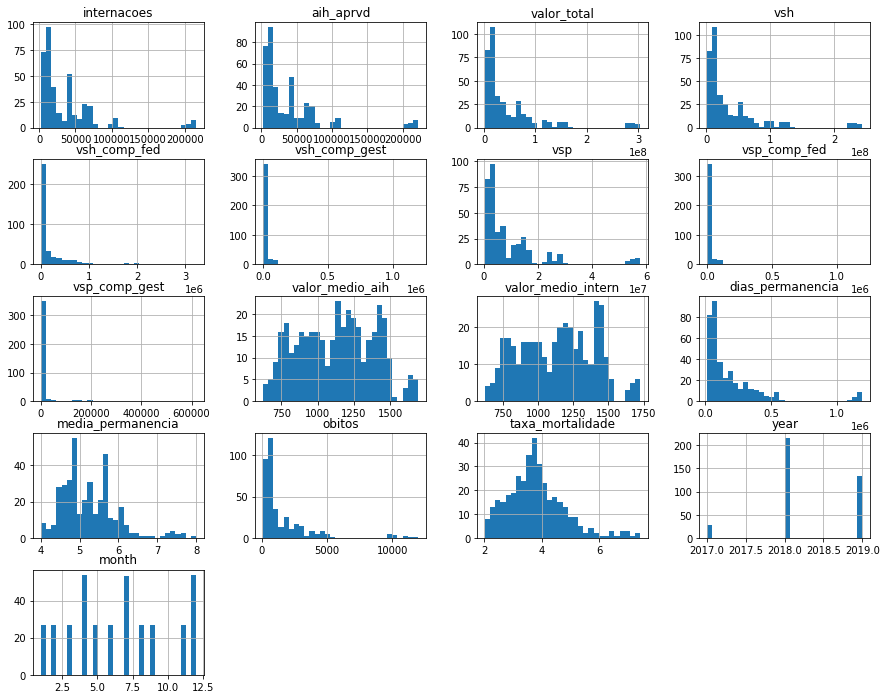

In [23]:
df3.hist(bins = 30, figsize = (15,12));

A princípio podemos perceber que a distribuição das internações e aih aprovadas são bem similares, assim como do valor total e do valor do serviço hospitalar (vsh). 

Dadas as descrições da variáveis isso é bastante razoável, já que a diferença entre internações e aih aprovadas são a não contabilização de prorrogação nas internações. Além disso, é razoável pensar que a maior parte dos gastos com internações seja por parte do hospital e não de pessoal.

Ambas as distribuições de valor do serviço hospitalar (vsh) complementar federal e gestor são concentradas à esquerda, porém a de gestor parece ser mais concentrada, o que pode dar a entender que o estado e município pagariam valores menores em comparação à federação. 

Entretanto, quando observamos o valor do serviço profissional (vsp) complementar, a distribuição correspondente ao estado e município possui alguns valores maiores do que o vsp federal.

Óbitos e taxa de mortalidade possuem uma distribuição similar, o que era esperado, já que a taxa de mortalidade leva em consideração o número de óbitos.

## 3.2 Análise Bivariada

Nessa análise, vamos comparar os valores das nossas variáveis *target* levando em consideração a análise simultânea de outras dimensões. Para isso, vamos criar alguas hipóteses sobre essas variáveis e, utilizando os dados, vamos explorar se elas são verdadeiras ou não.  

**Hipóteses a serem validadas**

* Hipóteses de Internações

 * 1- Existe um maior número de internações na região sudeste; 

 * 2- As internações ocorrem mais durante o inverno (junho-agosto);
 
 * 3- O número total de internações está reduzindo ao longo dos anos;


* Hipóteses de Valor total e médio da AIH

 * 1- A região com maior valor total das internações é a sudeste;

 * 2- Em média, a maior parte do valor total da AIH é relativo aos serviços hospitalares;

 * 3- Não existe sazonalidade no valor médio da AIH;

 * 4- A região com o maior valor médio de internação é a sudeste;
 
 * 5- A região com o maior valor médio de permanência é a sudeste;


* Óbitos e taxa de mortalidade

 * 1- A região com maior número de óbitos é a sudeste;

 * 2- Não existe sazonalidade na taxa de mortalidade;

 * 3- A quantidade total de óbitos e a taxa de mortalidade estão reduzindo ao longo dos anos;
 
 * 4- Os óbitos e a taxa de mortalidade médios anuais estão diminuindo;
 


### 3.2.1 Hipóteses de Internações (HI)

1- Existe um maior número de internações na região sudeste; 

**VERDADEIRA**. A região sudeste é a que possui maior número de internações, o que faz sentido, dado que é a região com maior população no país.

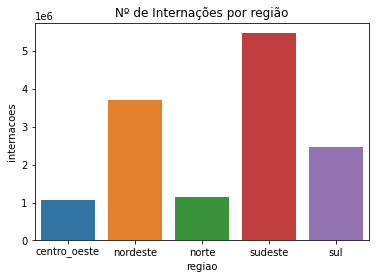

In [24]:
hi = df3[['regiao', 'internacoes']].groupby('regiao').sum().reset_index()
sns.barplot(x='regiao', y='internacoes', data= hi).set_title('Nº de Internações por região');

2- As internações ocorrem mais durante o inverno (junho-agosto);

Apesar de pelo gráfico parecer falsa, temos que lembrar que o conjuntos de dados não está completo em todos os meses. Quando observamos a contagem dos meses, os que mais aparecem são os que possuem um número maior de internações, logo não conseguimos extrair nenhuma informação relevante nesse momento.

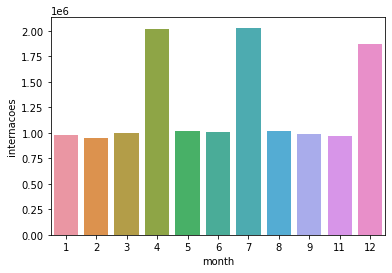

In [25]:
hi = df3[['month', 'internacoes']].groupby('month').sum().reset_index()
sns.barplot(x='month', y='internacoes', data = hi);

In [26]:
# observando as divergências de ocorrências entre os meses abordados
df3['month'].value_counts()

12    54
4     54
7     53
6     27
3     27
5     27
8     27
9     27
11    27
1     27
2     27
Name: month, dtype: int64

3- O número total de internações está reduzindo ao longo dos anos

Da mesma maneira que nossa última hipótese, a falta de dados históricos está prejudicando nossa análise. Portanto, não vamos concluir nada a princípio.

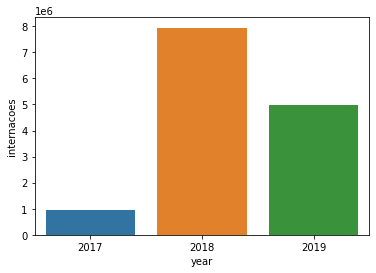

In [27]:
hi = df3[['year', 'internacoes']].groupby('year').sum().reset_index()
sns.barplot(x='year', y='internacoes', data = hi);

In [28]:
# observando as divergências de ocorrências entre os anos abordados
df3['year'].value_counts()

2018    216
2019    134
2017     27
Name: year, dtype: int64

### 3.2.2 Hipóteses de Valor Total e Médio (HVTM)

1- A região com maior valor total das internações é a sudeste.

**VERDADEIRO**. A região com o maior valor total de internações é a sudeste, o que faz sentido dado que é também a região com o maior número de internações.

<AxesSubplot:xlabel='regiao', ylabel='valor_total'>

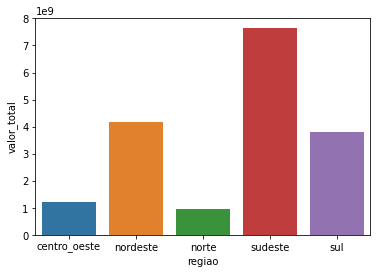

In [29]:
hvtm = df3[['regiao', 'valor_total']].groupby('regiao').sum().reset_index()
sns.barplot(x='regiao', y='valor_total', data=hvtm)

2- Em média, a maior parte do valor total da AIH é relativo aos serviços hospitalares

**VERDADEIRO**. Os valores de serviços hospitalares correspondem a 79.5% do valor total de internação, enquanto o valor dos serviços profissionais é 19.8%.

In [30]:
vsh_prop = df3['vsh'].sum()/df3['valor_total'].sum() *100
vsp_prop = df3['vsp'].sum()/df3['valor_total'].sum() *100

print("O valor hospitalar corresponde a {:.3}% do valor total enquanto o valor dos serviços corresponde a {:.3}%.".format(vsh_prop,vsp_prop))

O valor hospitalar corresponde a 79.5% do valor total enquanto o valor dos serviços corresponde a 19.8%.


3- Não existe sazonalidade no valor médio da AIH

**VERDADEIRO**. Ao longo dos meses registrados, não há uma variação grande do valor médio de AIH.

<AxesSubplot:xlabel='month', ylabel='valor_medio_aih'>

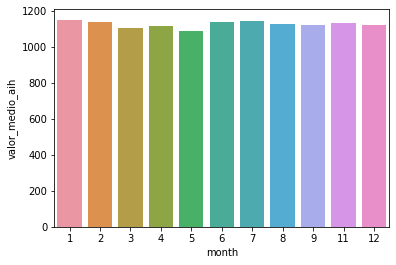

In [31]:
hvtm = df3[['month', 'valor_medio_aih']].groupby('month').mean().reset_index()
sns.barplot(x='month', y='valor_medio_aih', data = hvtm)

4- A região com o maior valor médio de internação é a sudeste.

**FALSO**. A região com o maior valor médio de internações é a sul.

<AxesSubplot:xlabel='regiao', ylabel='valor_medio_aih'>

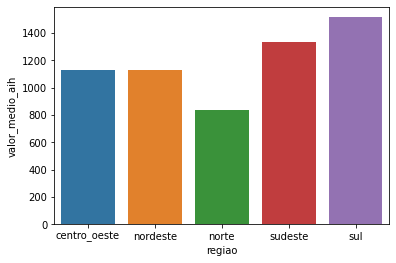

In [32]:
hvtm = df3[['regiao', 'valor_medio_aih']].groupby('regiao').mean().reset_index()
sns.barplot(x='regiao', y='valor_medio_aih', data=hvtm)

5- A região com o maior valor médio de permanência é a sudeste.

**FALSO**. A região com maior valor médio por dias de permanência é a região sul.

<AxesSubplot:xlabel='regiao', ylabel='media_valor_permanencia'>

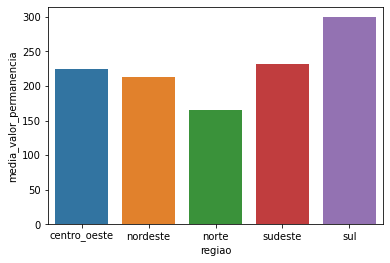

In [33]:
hvtm = df3[['regiao', 'valor_medio_aih', 'media_permanencia']].groupby('regiao').mean().reset_index()
hvtm['media_valor_permanencia'] = hvtm['valor_medio_aih'] / hvtm['media_permanencia']
sns.barplot(x='regiao', y='media_valor_permanencia', data = hvtm)

### 3.2.3. Hipóteses de Óbitos e Taxa de Mortalidade 

1- A região com maior número de óbitos é a sudeste.

**VERDADEIRO**. A região sudeste possui o maior número de óbitos nas nossas observações.

<AxesSubplot:xlabel='regiao', ylabel='obitos'>

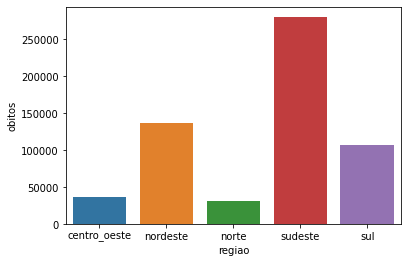

In [34]:
hotm = df3[['regiao', 'obitos']].groupby('regiao').sum().reset_index()
sns.barplot(data=hotm, x='regiao', y='obitos')

2- Não existe sazonalidade na taxa de mortalidade.

Parece haver uma sazonalidade, mas com os dados incompletos não conseguimos ter certeza dos movimentos.

<AxesSubplot:xlabel='month_year', ylabel='obitos'>

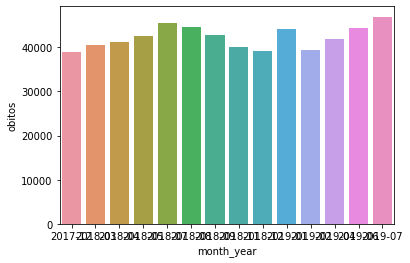

In [35]:
hotm = df3[['month_year', 'obitos']].groupby('month_year').sum().reset_index()
sns.barplot(x='month_year', y='obitos', data = hotm)

<AxesSubplot:xlabel='month', ylabel='obitos'>

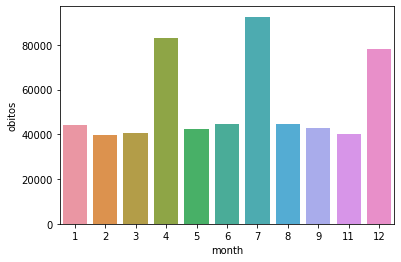

In [36]:
hotm = df3[['month', 'obitos']].groupby('month').sum().reset_index()
sns.barplot(x='month', y='obitos', data = hotm)

3- A quantidade total de óbitos e a taxa de mortalidade estão reduzindo ao longo dos anos;

A falta de amostras iguais para os anos não nos permite concluir essa hipótese.

<AxesSubplot:xlabel='year', ylabel='obitos'>

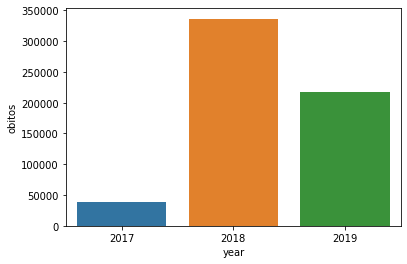

In [37]:
hotm = df3[['year', 'obitos']].groupby('year').sum().reset_index()
sns.barplot(x='year', y='obitos', data = hotm)

<AxesSubplot:xlabel='year', ylabel='taxa_mortalidade'>

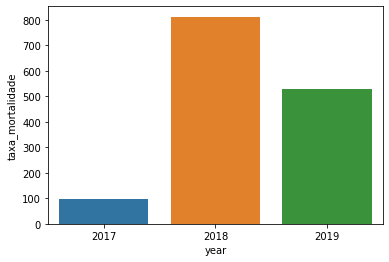

In [38]:
hotm = df3[['year', 'taxa_mortalidade']].groupby('year').sum().reset_index()
sns.barplot(x='year', y='taxa_mortalidade', data = hotm)

4- Os óbitos e a taxa de mortalidade médios anuais estão diminuindo;

**FALSO**. A média de óbitos e da taxa de mortalidade anuais estão aumentando.

<AxesSubplot:xlabel='year', ylabel='obitos'>

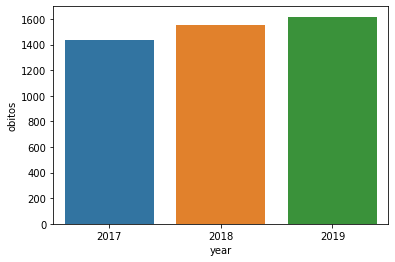

In [39]:
hotm = df3[['year', 'obitos']].groupby('year').mean().reset_index()
sns.barplot(x='year', y='obitos', data = hotm)

<AxesSubplot:xlabel='year', ylabel='taxa_mortalidade'>

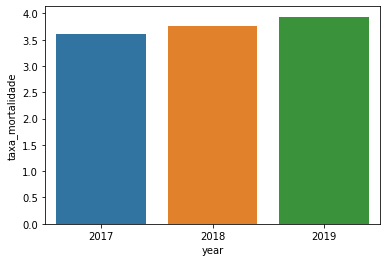

In [40]:
hotm = df3[['year', 'taxa_mortalidade']].groupby('year').mean().reset_index()
sns.barplot(x='year', y='taxa_mortalidade', data = hotm)

## 3.3 Análise Multivariada

Agora, vamos avaliar a correlação entre todas as variáveis de maneira simultânea.

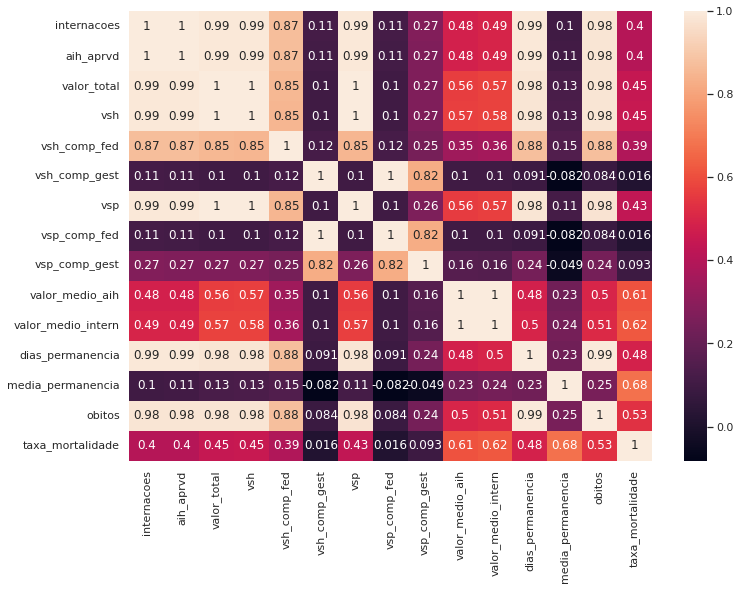

In [41]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(df3.select_dtypes(include='float64').corr(method='pearson'), annot = True);

Vamos analisar as variáveis de interesse:
* Internações: Como já vimos nas distribuições, existe uma correlação forte entre o nº de internações e aih aprovadas, o que faz sentido. Além disso, as internações também possui uma alta correlação com o valor total, já que quanto maior o número de internações, maior será o dispêndio nisso.
* Óbitos: O número de óbitos é obviamente proporcional ao número de internações, já que com o maior número de internações consequentemente serão computadas mais mortes. E, como é proporcional ao número de internações, acaba sendo altamente correlacionado com as outras variáveis relacionadas a ela. 
* Valor total: o custo total com internações é obviamente altamente correlacionado com o número total de internações.

Todas as variáveis de quantidade de internações e custo totais dessas internações (exceto pelo vsp complementar e vsh complementar do gestor) são altamente correlacionadas entre si e com as variáveis de óbitos totais e dias totais de permanência. 

Nenhuma dessas correlações é realmente uma surpresa, apenas confirma o que seria lógico.

# 4. Data Preparation

## 4.1. Estimando datas faltantes

A falta de dados históricos completos foi um empecilho considerável na nossa análise exploratória, portanto nosso próximo passo será tratar esses dados. As observações na nossa base de dados começam em dezembro de 2017 e vão até julho de 2019, nesse período temos seis meses faltando: 2018-01, 2018-02, 2018-06, 2018-10, 2019-03, 2019-05.  

Podemos estimar os valores de internações e valor total nos meses faltantes com algumas metodologias, entre elas:
* Mediana da variável, bom porque mantém a distribuição;
* Valor imediatamente anterior da variável, bom porque leva em consideração a tendência histórica;
* Média entre os valores anteriores e seguintes, bom porque mantém a tendência e é uma estimativa linear entre os valores anteriores e próximos.

No nosso caso, vamos utilizar a média entre os valores anteriores e próximos para estimar as variáveis. 



In [42]:
# criando as datas de referência futura
date = pd.date_range(df3['month_year'].min(), df3['month_year'].max(), freq='M' ).to_list()
df4 = pd.DataFrame()
df4['month_year'] = date
df4['month_year'] = df4['month_year'].apply(lambda x: datetime.strftime(x, '%Y-%m'))

# internações mensais
aux1 = df3[['month_year', 'internacoes']].groupby('month_year').sum().reset_index()

df4.loc[len(df4)] = aux1['month_year'].iloc[-1]
df4 = pd.merge(aux1, df4, how = 'right', on = 'month_year')

# valor_total por month_year
aux1 = df3[['month_year', 'valor_total']].groupby('month_year').sum().reset_index()
df4 = pd.merge(aux1, df4, how = 'right', on = 'month_year')

In [43]:
# criando coluna auxiliar para preencher dados nulos
df4['internacoes_ffill'] = df4['internacoes'].fillna(method = 'ffill')
df4['internacoes_bfill'] = df4['internacoes'].fillna(method = 'bfill')

df4['valor_ffill'] = df4['valor_total'].fillna(method = 'ffill')
df4['valor_bfill'] = df4['valor_total'].fillna(method = 'bfill')

# preenchendo valores
df4['valor_total'] = (df4['valor_ffill'] + df4['valor_bfill'])/2
df4['internacoes'] = (df4['internacoes_ffill'] + df4['internacoes_bfill'])/2

In [44]:
# montando nossa df final com os períodos que faltavam preenchidos pela média entre períodos
df4 = df4[['month_year', 'valor_total', 'internacoes']]
df4['month_year'] = pd.to_datetime(df4['month_year'])
df4['month'] = df4['month_year'].dt.month
df4['year'] = df4['month_year'].dt.year
df4['month_year'] = df4['month_year'].apply(lambda x: datetime.strftime(x, '%Y-%m'))
df4

,month_year,valor_total,internacoes,month,year
0,2017-12,1201828188.240,939601.000,12,2017
1,2018-01,1225699479.905,966911.500,1,2018
2,2018-02,1225699479.905,966911.500,2,2018
3,2018-03,1249570771.570,994222.000,3,2018
4,2018-04,1265569345.190,1006271.000,4,2018
5,2018-05,1279917419.730,1018405.000,5,2018
6,2018-06,1290689956.310,1016210.500,6,2018
7,2018-07,1301462492.890,1014016.000,7,2018
8,2018-08,1316574487.520,1020220.000,8,2018
9,2018-09,1272478809.490,988931.000,9,2018


## 4.2 DF Internações

Como temos o objetivo de fazer a previsão de 6 meses após o fim dos nossos dados das internações, óbitos e valor médio aih, vamos preparar dataframes estratégicos para esse objetivo.

In [45]:
df_internacoes = df4[['month_year', 'internacoes']]
df_internacoes.head()

,month_year,internacoes
0,2017-12,939601.000
1,2018-01,966911.500
2,2018-02,966911.500
3,2018-03,994222.000
4,2018-04,1006271.000


## 4.3 DF Óbitos

In [46]:
aux1 = df3[['month_year', 'obitos']].groupby('month_year').sum().reset_index()
df4 = pd.merge(aux1, df4, how = 'right', on = 'month_year')
df4['obitos_ffill'] = df4['obitos'].fillna(method = 'ffill')
df4['obitos_bfill'] = df4['obitos'].fillna(method = 'bfill')
df4['obitos'] = (df4['obitos_ffill'] + df4['obitos_bfill'])/2

In [47]:
df_obitos = df4[['month_year', 'internacoes','obitos']]
df_obitos.head()

,month_year,internacoes,obitos
0,2017-12,939601.000,38881.000
1,2018-01,966911.500,39685.500
2,2018-02,966911.500,39685.500
3,2018-03,994222.000,40490.000
4,2018-04,1006271.000,41111.000


## 4.2 DF Valor Médio AIH

In [48]:
aux1 = df3[['month_year', 'valor_medio_aih']].groupby('month_year').mean().reset_index()
df4 = pd.merge(aux1, df4, how = 'right', on = 'month_year')
df4['vmaih_ffill'] = df4['valor_medio_aih'].fillna(method = 'ffill')
df4['vmaih_bfill'] = df4['valor_medio_aih'].fillna(method = 'bfill')
df4['valor_medio_aih'] = (df4['vmaih_ffill'] + df4['vmaih_bfill'])/2

In [49]:
df_vmaih = df4[['month_year', 'internacoes', 'valor_total', 'valor_medio_aih']]
df_vmaih.head()

,month_year,internacoes,valor_total,valor_medio_aih
0,2017-12,939601.000,1201828188.240,1109.117
1,2018-01,966911.500,1225699479.905,1106.674
2,2018-02,966911.500,1225699479.905,1106.674
3,2018-03,994222.000,1249570771.570,1104.230
4,2018-04,1006271.000,1265569345.190,1099.852


# 5. Modelo

Para criarmos modelos capazes de prever os valores de internações, número de óbitos e valor médio de AIH pelos próximos 6 meses temos que analisar nossas variáveis resposta.

* **Internações**

    Dentro da nossa base de dados, temos variáveis altamente correlacionadas com as internações, como aih autorizadas, valor total, vsh, etc. Porém, quando paramos para pensar em modelos preditivos entendemos que essas variáveis, apesar de serem altamente correlacionadas, não serão úteis para a criação do modelo. 

    Isso ocorre porque elas são dependentes dos números de internações, não causadoras. Para prever o número de internações pelos próximos 6 meses precisamos de variáveis que causam o número de internações e estejam disponíveis antes do período que queremos prever. 
    
    Como não possuímos variáveis explicadoras, trataremos o modelo como uma série temporal auto regressiva. 
    
    
* **Óbitos**

    Também possuímos variáveis altamente correlacionadas com o número de óbitos, como internações. Entretanto, apesar de serem causadoras do número de óbitos, no sentido de que é preciso ter a internação para podermos contabilizar o óbito, não possuímos a informação de internação previamente. Enquanto a computação de internações está sendo feita, temos também a contabilização dos óbitos no mesmo período. 
    Portanto, o que usaremos são as internações do período anterior para estimar os óbitos do período atual. 
    
    
* **Valor médio de AIH**
    
    O valor de internações segue o mesmo racional dos óbitos, apesar de altamente correlacionado com as internações, elas são computadas e ocorrem simultaneamente. Por conta disso, utilizaremos a informação histórica de internações e valor total de internação para estimarmos o valor médio da AIH atual. 

In [50]:
df5 = df4.copy()

## 5.1 Internações

### 5.1.1 Modelo Naive

O modelo naive é um modelo básico de séries temporais cuja premissa é que o valor de t será igual ao valor t-1. Esse modelo dificilmente apresenta um bom resultado e será usado como baseline, apenas para termos uma estimativa base para comparar o outro modelo. 

In [51]:
df_internacoes = df_internacoes[['month_year', 'internacoes']]
df_internacoes['month_year'] = pd.to_datetime(df_internacoes['month_year']) 
df_internacoes.set_index('month_year', inplace=True)

In [52]:
df_internacoes['naive'] = df_internacoes['internacoes'].shift(1)

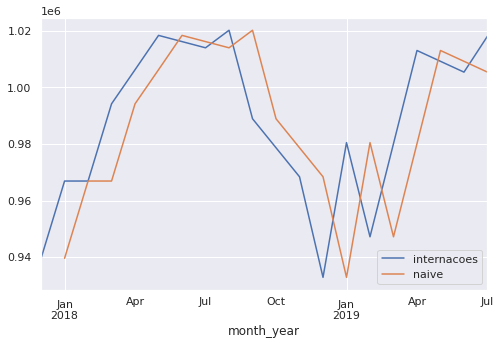

In [53]:
df_internacoes.plot(figsize=(8,5));

Como métrica de avaliação do modelo, vamos usar a média de erro absoluta (MAE) e média de erro quadrático (MSE). A MAE mostra, em média, quanto erramos na previsão de cada um dos meses enquando a MSE mostra a média dos erros ao quadrado. 

Por mais que seja mais fácil de interpretar a MAE a importância da MSE é nos mostrar se estamos errando os valores por grande diferença ou pequena. A MAE pode acabar apresentando um valor pequeno caso nossa grandeza de erros para mais e menos seja similar, e.g., se eu errar a previsão por -100.000 em um mês e + 100.000 em outro mês a média será zero, o uqe pode dar a impressão de não haver erro. 

A MSE mostra a grandeza do nosso erro de maneira absoluta, já que eleva ao quadrado os valores, tornando os valores negativos em positivos.


In [54]:
mae = mean_absolute_error(df_internacoes['internacoes'].iloc[2:], df_internacoes['naive'].iloc[2:])
mse = mean_squared_error(df_internacoes['internacoes'].iloc[2:], df_internacoes['naive'].iloc[2:])

print("O erro absoluto médio mensal é de {:,.6} enquanto o erro quadrático médio mensal é de {:,.10}.".format(mae, mse))

O erro absoluto médio mensal é de 17,588.4 enquanto o erro quadrático médio mensal é de 515,407,443.8.


### 5.1.2 Modelo AutoRegressivo 

#### 5.1.2.1 Um lag

In [55]:
df_internacoes['lag1'] = df_internacoes['internacoes'].shift(1)
df_internacoes.dropna(axis = 0, inplace = True)

In [56]:
ar1 = AutoReg(df_internacoes['internacoes'], lags = 1).fit()

/home/julia-penalva/.pyenv/versions/3.10.1/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [57]:
mae = ar1.resid.mean()
mse = (ar1.resid ** 2).mean()
print("O erro absoluto médio mensal é de {:,.5} enquanto o erro quadrático médio mensal é de {:,.10}.".format(mae, mse))

O erro absoluto médio mensal é de -4.2039e-10 enquanto o erro quadrático médio mensal é de 409,253,112.3.


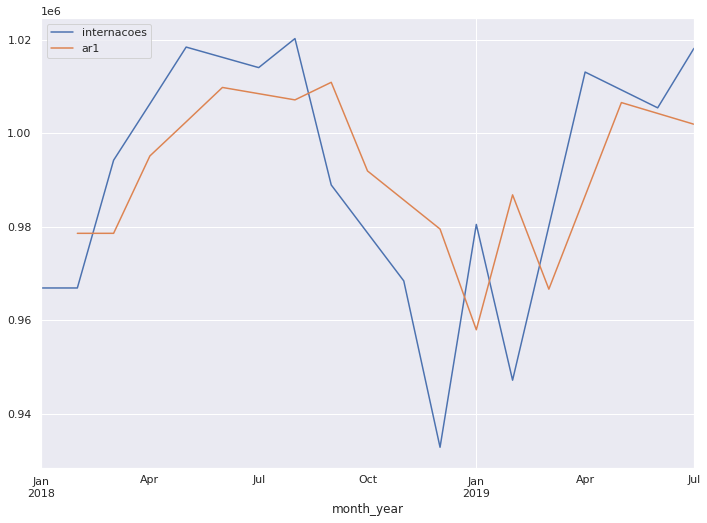

In [58]:
df_internacoes['ar1'] = ar1.predict()
df_internacoes[['internacoes', 'ar1']].plot();

#### 5.1.2.2 Dois lags

In [59]:
df_internacoes['lag1'] = df_internacoes['internacoes'].shift(1)
df_internacoes['lag2'] = df_internacoes['internacoes'].shift(2)
df_internacoes.dropna(axis = 0, inplace = True)

In [60]:
ar2 = AutoReg(df_internacoes['internacoes'], lags = 2).fit()
mae = ar2.resid.mean()
mse = (ar2.resid ** 2).mean()
print("O erro absoluto médio mensal é de {:,.5} enquanto o erro quadrático médio mensal é de {:,.10}.".format(mae, mse))

O erro absoluto médio mensal é de -3.8805e-10 enquanto o erro quadrático médio mensal é de 444,161,170.4.


/home/julia-penalva/.pyenv/versions/3.10.1/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


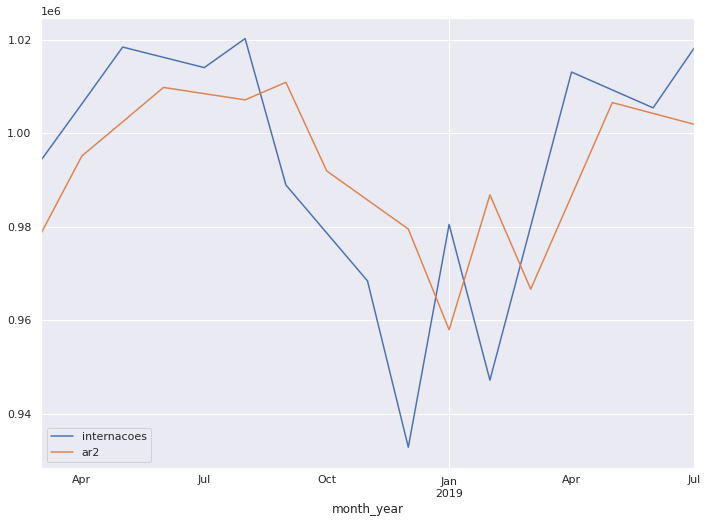

In [61]:
df_internacoes['ar2'] = ar1.predict()
df_internacoes[['internacoes', 'ar2']].plot();

Testamos o modelo de 1 e 2 lags para a previsão do valor futuro das internações, ambos com resultado melhor que o Naive. Entretando o modelo de 1 lag possui um erro menor, então será utilizado para prever os próximos 6 meses. 

Isso ocorre provavelmente porque, com o maior número de lags criados, temos que nos livrar das linhas que ficam com valores nulos e como nossa amostra é pequena essa perda de informação afeta negativamente o modelo.

### 5.1.3 Previsão

In [62]:
prev = pd.DataFrame(data = ar1.predict('2019-08-01', '2020-01-01'));
prev.rename(columns ={0: 'internacoes'})

/home/julia-penalva/.pyenv/versions/3.10.1/lib/python3.10/site-packages/statsmodels/tsa/deterministic.py:152: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and NumericIndex with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


,internacoes
2019-08-01,1009604.133
2019-09-01,1004444.541
2019-10-01,1001320.282
2019-11-01,999428.468
2019-12-01,998282.929
2020-01-01,997589.277


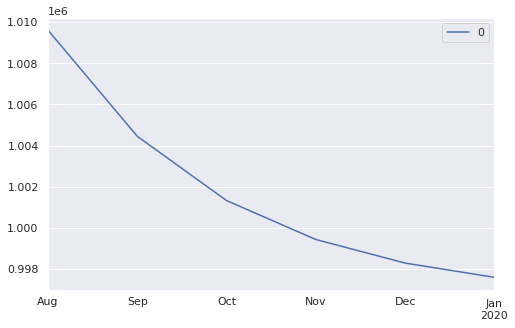

In [63]:
prev.plot(figsize = (8,5));

Apesar de estarmos prevendo os valores dos próximos 6 meses, o ideal era que o modelo fosse utilizado somente para prever o valor imediatamente posterior ao último dado que efetivamente ocorreu. Logo, a previsão seria feita somente de Agosto/2019.

Isso ocorre porque, prevendo mais de um período, estamos utilizando as próprias previsões que fizemos como input do modelo, não dados reais, e isso acaba 'contaminando' o modelo.

## 5.2 Óbitos

In [64]:
df_obitos.head()

,month_year,internacoes,obitos
0,2017-12,939601.000,38881.000
1,2018-01,966911.500,39685.500
2,2018-02,966911.500,39685.500
3,2018-03,994222.000,40490.000
4,2018-04,1006271.000,41111.000


### 5.2.1 Modelo Naive

Nosso modelo base para a previsão de óbitos:

In [65]:
df_obitos['month_year'] = pd.to_datetime(df_obitos['month_year']) 
df_obitos.set_index('month_year', inplace=True)
df_obitos['naive'] = df_obitos['obitos'].shift(1)

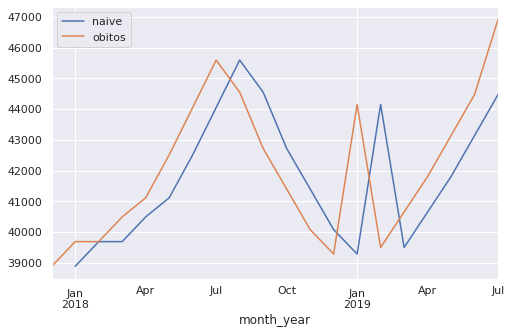

In [66]:
df_obitos[['naive', 'obitos']].plot(figsize=(8,5));

In [67]:
mae = mean_absolute_error(df_obitos['obitos'].iloc[2:], df_obitos['naive'].iloc[2:])
mse = mean_squared_error(df_obitos['obitos'].iloc[2:], df_obitos['naive'].iloc[2:])

print("O erro absoluto médio mensal é de {:,.6} enquanto o erro quadrático médio mensal é de {:,.10}.".format(mae, mse))

O erro absoluto médio mensal é de 1,620.69 enquanto o erro quadrático médio mensal é de 4,104,793.514.


### 5.2.2 Regressão Linear

Para as internações, usamos um modelo autoregressivo, que utiliza os lags da própria variável target para prever os valores futuros. No caso dos óbitos, vamos usar o lag da variável, mas também usaremos o lag das internações, já que a quantidade de óbitos é altamente correlacionada com ela.

In [68]:
df_obitos.rename(columns={'naive': 'lag1'}, inplace = True)
df_obitos['internacoes_lag'] = df_obitos['internacoes'].shift(1)
df_obitos.dropna(axis = 0, inplace = True)

In [69]:
# definindo x e y
X = df_obitos.drop(['obitos','internacoes'], axis = 1)
y = df_obitos['obitos']

# definindo dados de treino e teste
train_size = 0.75
X_train = X.iloc[:int(len(df_obitos)*train_size)]
X_test = X.iloc[int(len(df_obitos)*train_size):]
y_train = y.iloc[:int(len(df_obitos)*train_size)]
y_test = y.iloc[int(len(df_obitos)*train_size):]

# configurando modelo
reg = LinearRegression()

In [70]:
# treinando modelo
reg.fit(X_train, y_train)

# predizendo valores
y_pred = reg.predict(X_test)

# avaliação do modelo
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("O erro absoluto médio é de {:,.5} e o erro quadrático é de {:,.10}.".format(mae,mse))

O erro absoluto médio é de 1,435.3 e o erro quadrático é de 4,012,992.999.


Nosso modelo de regressão tem resultado superior ao nosso baseline, então usaremos ele para a previsão de 6 meses.

### 5.2.1 Previsão 

In [71]:
# usando os últimos dados reais que possuimos para prever o período imediatamente seguinte
# precisamos trocar o nome das colunas para o mesmo que treinamos o modelo
X_total = df_obitos[['obitos', 'internacoes']]
X_total.rename(columns={'internacoes':'internacoes_lag', 'obitos': 'lag1'}, inplace = True)
previ = reg.predict(X_total)

/home/julia-penalva/.pyenv/versions/3.10.1/lib/python3.10/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [72]:
# acrescentando a previsão de óbitos no nosso df prev
prev = pd.concat([prev, pd.DataFrame(columns = ['previsao_obitos'])])
prev['previsao_obitos'].iloc[0] = previ[len(previ)-1]
prev.rename(columns = {0: 'previsao_internacoes'}, inplace = True)

/home/julia-penalva/.pyenv/versions/3.10.1/lib/python3.10/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [73]:
# previsão do segundo período
X_total = pd.DataFrame(prev.iloc[0]).T
y = reg.predict(X_total)
y=y[0]
prev['previsao_obitos'].iloc[1] = y

/home/julia-penalva/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- previsao_internacoes
- previsao_obitos
Feature names seen at fit time, yet now missing:
- internacoes_lag
- lag1

  warnings.warn(message, FutureWarning)
/home/julia-penalva/.pyenv/versions/3.10.1/lib/python3.10/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [74]:
# prevendo o segundo é possível perceber um padrão para fazer a previsão dos próximos períodos,
# com isso conseguimos automatizar essa parte:
for i in range(2, len(prev)):
    X_total = pd.DataFrame(prev.iloc[i-1]).T
    y=reg.predict(X_total)
    y = y[0]
    prev['previsao_obitos'].iloc[i] = y

/home/julia-penalva/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- previsao_internacoes
- previsao_obitos
Feature names seen at fit time, yet now missing:
- internacoes_lag
- lag1

  warnings.warn(message, FutureWarning)
/home/julia-penalva/.pyenv/versions/3.10.1/lib/python3.10/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/julia-penalva/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error 

In [75]:
prev

,previsao_internacoes,previsao_obitos
2019-08-01,1009604.133,43751.284
2019-09-01,1004444.541,225625.996
2019-10-01,1001320.282,229263.315
2019-11-01,999428.468,228685.468
2019-12-01,998282.929,228262.977
2020-01-01,997589.277,228005.254


Agora temos também os resultados das previsões de óbitos. Lembrando que a mesma ressalva que foi feita no caso das previsões de internaçõe segue aqui: estamos usando dados que prevemos para fazer previsões de prazos posteriores, o que não é recomendado.

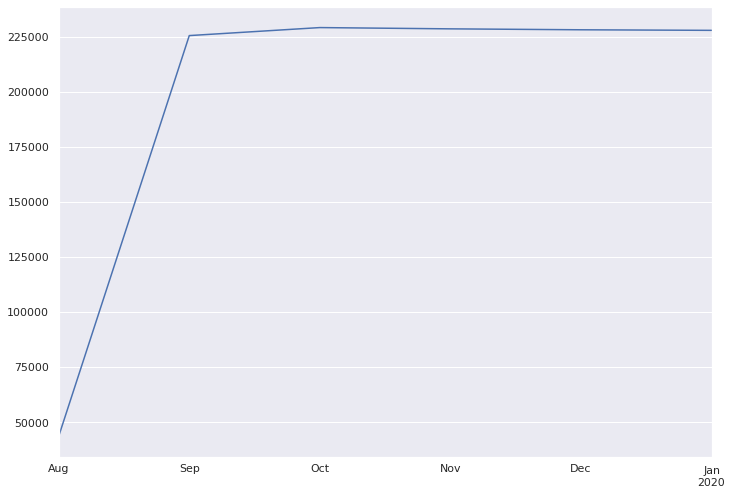

In [76]:
prev['previsao_obitos'].plot();

## 5.3 Valor Médio de AIH 

Para o valor médio de AIH, vamos usar a mesma lógica que usamos para óbitos. Vamos usar as informações de internacoes e valor total disponíveis no período anterior para estimarmos o valor médio de aih do período atual. 

Como queremos uma projeção de 6 meses, isso quer dizer que vamos ter que fazer o mesmo exercício de previsão para o valor total antes de prevermos o valor médio de AIH. 

In [77]:
df_vt = df_vmaih.drop('valor_medio_aih', axis = 1).copy() 

### 5.3.1 Previsão Valor Total de AIH

#### 5.3.1.1 Naive

In [78]:
df_vt['month_year'] = pd.to_datetime(df_vt['month_year']) 
df_vt.set_index('month_year', inplace=True)
df_vt['naive'] = df_vt['valor_total'].shift(1)

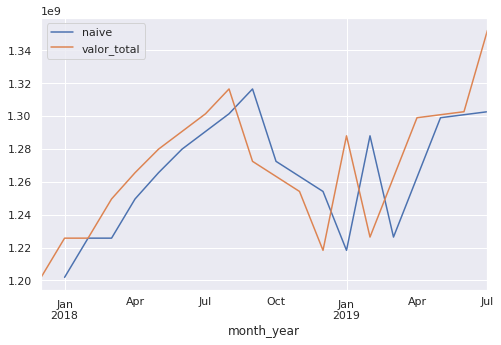

In [79]:
df_vt[['naive', 'valor_total']].plot(figsize=(8,5));

In [80]:
mae = mean_absolute_error(df_vt['valor_total'].iloc[2:], df_vt['naive'].iloc[2:])
mse = mean_squared_error(df_vt['valor_total'].iloc[2:], df_vt['naive'].iloc[2:])

print("O erro absoluto médio mensal é de {:,.6} enquanto o erro quadrático médio mensal é de {:,.10}.".format(mae, mse))

O erro absoluto médio mensal é de 2.48097e+07 enquanto o erro quadrático médio mensal é de 1.037296633e+15.


#### 5.3.1.2 Regressão Linear

In [81]:
df_vt['internacoes_lag'] = df_vt['internacoes'].shift(1)
df_vt['valor_total_lag'] = df_vt['valor_total'].shift(1)
df_vt.dropna(axis = 0, inplace = True)

In [82]:
# set X and y
X = df_vt[['internacoes_lag', 'valor_total_lag']]
y = df_vt['valor_total']

# define train and test set
train_size = 0.75
X_train = X.iloc[:int(len(df_vt)*train_size)]
X_test = X.iloc[int(len(df_vt)*train_size):]
y_train = y.iloc[:int(len(df_vt)*train_size)]
y_test = y.iloc[int(len(df_vt)*train_size):]

# set model
reg = LinearRegression()

In [83]:
# training model
reg.fit(X_train, y_train)

# predicting values
y_pred = reg.predict(X_test)

# evaluating model

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("O erro absoluto médio é de {:,.5} e o erro quadrático é de {:,.10}.".format(mae,mse))

O erro absoluto médio é de 3.8032e+07 e o erro quadrático é de 1.896463097e+15.


Nosso modelo de regressão teve performance inferior ao modelo naive, por isso usaremos o modelo mais simples para prever nosso valor total. Porém, isso vai fazer com que o nosso valor fique constante a partir do segundo mês previsto, já que não temos as ocorrências reais para balizar.

### 5.3.2 Previsão Valor Total

In [84]:
# joining the obitos prevision with the internacoes
prev = pd.concat([prev, pd.DataFrame(columns = ['previsao_vt'])])
prev['previsao_vt'].iloc[0] = df_vt['valor_total'].iloc[len(df_vt)-1]
prev['previsao_vt'].ffill(axis = 0, inplace = True)

/home/julia-penalva/.pyenv/versions/3.10.1/lib/python3.10/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [85]:
prev

,previsao_internacoes,previsao_obitos,previsao_vt
2019-08-01,1009604.133,43751.284,1352327454.580
2019-09-01,1004444.541,225625.996,1352327454.580
2019-10-01,1001320.282,229263.315,1352327454.580
2019-11-01,999428.468,228685.468,1352327454.580
2019-12-01,998282.929,228262.977,1352327454.580
2020-01-01,997589.277,228005.254,1352327454.580


### 5.3.3. Modelo Valor Médio AIH

In [86]:
df_vmaih

,month_year,internacoes,valor_total,valor_medio_aih
0,2017-12,939601.000,1201828188.240,1109.117
1,2018-01,966911.500,1225699479.905,1106.674
2,2018-02,966911.500,1225699479.905,1106.674
3,2018-03,994222.000,1249570771.570,1104.230
4,2018-04,1006271.000,1265569345.190,1099.852
5,2018-05,1018405.000,1279917419.730,1089.775
6,2018-06,1016210.500,1290689956.310,1104.390
7,2018-07,1014016.000,1301462492.890,1119.005
8,2018-08,1020220.000,1316574487.520,1125.486
9,2018-09,988931.000,1272478809.490,1122.483


#### 5.3.3.1 Naive

In [87]:
df_vmaih['month_year'] = pd.to_datetime(df_vmaih['month_year']) 
df_vmaih.set_index('month_year', inplace=True)
df_vmaih['naive'] = df_vmaih['valor_medio_aih'].shift(1)

/tmp/ipykernel_14537/491521400.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vmaih['month_year'] = pd.to_datetime(df_vmaih['month_year'])
/tmp/ipykernel_14537/491521400.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vmaih['naive'] = df_vmaih['valor_medio_aih'].shift(1)


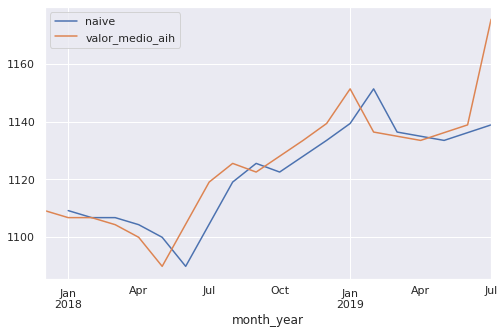

In [88]:
df_vmaih[['naive', 'valor_medio_aih']].plot(figsize=(8,5));

In [89]:
mae = mean_absolute_error(df_vmaih['valor_medio_aih'].iloc[2:], df_vmaih['naive'].iloc[2:])
mse = mean_squared_error(df_vmaih['valor_medio_aih'].iloc[2:], df_vmaih['naive'].iloc[2:])

print("O erro absoluto médio mensal é de {:,.6} enquanto o erro quadrático médio mensal é de {:,.10}.".format(mae, mse))

O erro absoluto médio mensal é de 8.02102 enquanto o erro quadrático médio mensal é de 134.9796113.


#### 5.3.3.2 Regressão

In [90]:
df_vmaih['internacoes_lag'] = df_vmaih['internacoes'].shift(1)
df_vmaih['valor_total_lag'] = df_vmaih['valor_total'].shift(1)
df_vmaih['vmaih_lag'] = df_vmaih['valor_medio_aih'].shift(1)
df_vmaih.dropna(axis = 0, inplace = True)

/tmp/ipykernel_14537/3339968311.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vmaih['internacoes_lag'] = df_vmaih['internacoes'].shift(1)
/tmp/ipykernel_14537/3339968311.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vmaih['valor_total_lag'] = df_vmaih['valor_total'].shift(1)
/tmp/ipykernel_14537/3339968311.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

In [91]:
# set X and y
X = df_vmaih[['internacoes_lag', 'valor_total_lag', 'vmaih_lag']]
y = df_vmaih['valor_medio_aih']

# define train and test set
train_size = 0.75
X_train = X.iloc[:int(len(df_vmaih)*train_size)]
X_test = X.iloc[int(len(df_vmaih)*train_size):]
y_train = y.iloc[:int(len(df_vmaih)*train_size)]
y_test = y.iloc[int(len(df_vmaih)*train_size):]

# set model
reg = LinearRegression()

In [92]:
# training model
reg.fit(X_train, y_train)

# predicting values
y_pred = reg.predict(X_test)

# evaluating model

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("O erro absoluto médio é de {:,.5} e o erro quadrático é de {:,.10}.".format(mae,mse))

O erro absoluto médio é de 16.811 e o erro quadrático é de 462.7684414.


Assim como na previsão de valor total, o valor médio também é melhor previsto simplesmente pelo seu valor anterior, através do modelo Naive, então utilizaremos ele para fazer a previsão.

### 5.3.1 Previsão

In [93]:
# acrescentando a previsão de valor médio ao nosso df de previsões
prev = pd.concat([prev, pd.DataFrame(columns = ['previsao_media_aih'])])
prev['previsao_media_aih'].iloc[0] = df_vmaih['valor_medio_aih'].iloc[len(df_vmaih)-1]

/home/julia-penalva/.pyenv/versions/3.10.1/lib/python3.10/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [94]:
prev['previsao_media_aih'].ffill(inplace=True)

In [95]:
prev

,previsao_internacoes,previsao_obitos,previsao_vt,previsao_media_aih
2019-08-01,1009604.133,43751.284,1352327454.580,1175.484
2019-09-01,1004444.541,225625.996,1352327454.580,1175.484
2019-10-01,1001320.282,229263.315,1352327454.580,1175.484
2019-11-01,999428.468,228685.468,1352327454.580,1175.484
2019-12-01,998282.929,228262.977,1352327454.580,1175.484
2020-01-01,997589.277,228005.254,1352327454.580,1175.484


# 6. Planejamento estratégico

Para realizar um planejamento visando reduzir o número de informações, deveriamos lidar com variáveis causadoras das internações, dados que não tivemos acesso na nossa base original.

A relação deveria ser estudada, mas possíveis explicações para o número de internações poderia ser a população do local, o número de acidentes, o clima, campanhas de vacinação na região e sua adesão, índices de criminalidade, saneamento feito na região, etc. Poderíamos ter uma noção melhor se tivéssemos uma base de dados com todas as internações e a causa delas, assim poderíamos estudar as principais doenças ou acidentes que causam internações e estudar as principais causas de cada uma das doenças. 

Dessa forma, para reduzir o número de internações deveria ser feito um estudo das principais causas de internações e procurar atuar para reduzir essas causas.

Essa visão geral de pesquisa e entendimento de situação funcionaria para qualquer cidade ou UF estudada. 

Com essa base de dados o máximo que conseguimos é inferir o número de internações, óbitos e valores levando em consideração os valores anteriores das variáveis, preferencialmente somente para o período imediatamente seguinte.